# gwexpy Plotting Introduction

このノートブックでは、`gwexpy` の強化されたプロット機能を紹介します。
`TimeSeriesMatrix` や `FrequencySeriesMatrix` などの行列データ構造、および `SpectrogramList` などのコレクションに対する、「いい感じ」のデフォルト設定（figsize自動調整、対数軸、レイアウト、軸ラベル）についてデモを行います。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.frequencyseries import (
    FrequencySeries,
    FrequencySeriesList,
    FrequencySeriesMatrix,
)
from gwexpy.spectrogram import Spectrogram, SpectrogramList
from gwexpy.timeseries import TimeSeries, TimeSeriesMatrix

# ランダムシードの固定
np.random.seed(42)

/home/runner/miniconda3/envs/docs/lib/python3.11/site-packages/gwpy/time/_ligotimegps.py:42: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


AttributeError: module 'gwpy.io.registry' has no attribute 'register_reader'

## 1. TimeSeriesMatrix Plotting

`TimeSeriesMatrix` は (Row, Col, Time) の3次元構造を持つ時系列データを管理します。
`.plot()` を呼び出すと、以下の最適化が行われます：
- **軸ラベル**: `determine_xlabel` により "Time [s]" や "Time [s] from ..." が自動設定されます。
- **Auto-GPS**: 時間軸の場合、デフォルトで `auto-gps` スケールが適用され、GPS時刻（大きなオフセット）が適切に処理されます。
- **レイアウト**: 行・列の構造に合わせて `figsize` が自動調整されます。


In [2]:
# 2x2 の TimeSeriesMatrix を作成
# GPS時刻 (例: 1356998418 = 2023-01-01 00:00:00 UTC) からの10秒間
t0 = 1356998418.0
times = t0 + np.linspace(0, 10, 1000)
data = np.random.randn(2, 2, 1000)
# 行: Sensor A, B / 列: Axis X, Y
tsm = TimeSeriesMatrix(
    data,
    times=times,
    unit="m",
    name="Velocity",
    rows=["Sensor A", "Sensor B"],
    cols=["X-axis", "Y-axis"],
)

# プロット
plot = tsm.plot()
plot.show();

NameError: name 'TimeSeriesMatrix' is not defined

## 2. FrequencySeriesMatrix Plotting

`FrequencySeriesMatrix` は (Row, Col, Frequency) の3次元構造を持つ周波数データを管理します。
一般的なスペクトル解析の結果などを保持します。
`.plot()` の特徴：
- **対数軸**: データサイズ等の条件に応じて、X軸（周波数）やY軸（振幅）が自動的に対数スケールになります。
- **軸ラベル**: "Frequency [Hz]" や "[unit]" が自動設定されます。


In [3]:
# FrequencySeriesMatrix の作成
# 10Hz から 1kHz
f = np.logspace(1, 3, 500)
# 1/f ノイズのようなデータを生成
data = np.zeros((2, 2, 500))
for i in range(2):
    for j in range(2):
        data[i, j, :] = 10 / f * (1 + 0.1 * np.random.randn(500)) + (i + j)

# unit='m' (Amplitude Spectral Density と仮定すると m/sqrt(Hz) ですが、ここでは単純化)
fsm = FrequencySeriesMatrix(
    data,
    frequencies=f,
    unit="m",
    name="Displacement",
    rows=["Sensor A", "Sensor B"],
    cols=["X-axis", "Y-axis"],
)

# プロット
# 自動的に log-log プロットになることを確認してください
plot = fsm.plot()
plot.show();

NameError: name 'FrequencySeriesMatrix' is not defined

## 3. FrequencySeriesList Plotting (参考)

`FrequencySeriesList` (または Dict) は、グリッド構造を持たない単純なリストです。
これも同様にプロット可能です。


In [4]:
# FrequencySeriesList の作成
fs1 = FrequencySeries(1 / f, frequencies=f, unit=u.m, name="Series 1")
fs2 = FrequencySeries(2 / f, frequencies=f, unit=u.m, name="Series 2")

fs_list = FrequencySeriesList([fs1, fs2])

fs_list.plot();

NameError: name 'FrequencySeries' is not defined

In [5]:
del times, data, tsm, fsm, fs1, fs2, fs_list

import gc

gc.collect()

NameError: name 'tsm' is not defined

## 4. SpectrogramList Plotting

`SpectrogramList` のプロットは、デフォルトで `geometry=(N, 1)` の縦並びレイアウト、対数カラーバーなどが適用されます。
スペクトログラムも時間軸を持つため、GPS時刻を与えると `auto-gps` が機能します。


In [6]:
# Spectrogram の作成
# TimeSeriesMatrix と同じ GPS 時刻を使用
t = t0 + np.linspace(0, 10, 100)
# 10Hz - 1000Hz
f = np.logspace(1, 3, 50)

spec_list = SpectrogramList(
    [
        Spectrogram(
            np.random.rand(100, 50), times=t, frequencies=f, unit=u.count, name="Spec 1"
        ),
        Spectrogram(
            np.random.rand(100, 50) * 10,
            times=t,
            frequencies=f,
            unit=u.count,
            name="Spec 2",
        ),
    ]
)
spec_list.plot();

NameError: name 'SpectrogramList' is not defined

## 4. Adaptive Plotting Optimization (Decimation)

大量のデータを持つ `TimeSeries` をプロットする際、描画パフォーマンスを維持するために自動的に間引き（Min-Max Decimation）を適用します。
- **自動適用**: デフォルトではサンプル数が 50,000 を超える場合に発動します。
- **ピーク維持**: Min-Max アルゴリズムにより、波形のエンベロープ（最大・最小）を保持したままデータ点を削減（デフォルト 約10,000点）します。
- **カスタマイズ**: `decimate_threshold` や `decimate_points` 引数で制御可能です。

In [7]:
# 100,000,000 サンプルのデータを生成
ts_large = TimeSeries(np.random.randn(100000000), sample_rate=1024, name="Large TS")

print(f"Original samples: {len(ts_large)}")

# プロット実行 (自動的に間引きが行われる)
plot_opt = ts_large.plot()

# 描画された点数を確認
ax = plot_opt.gca()
line = ax.get_lines()[0]
print(f"Plotted points: {len(line.get_xdata())}")
plot_opt.show();

NameError: name 'TimeSeries' is not defined

### コレクション・行列への適用とパラメータ指定

`TimeSeriesList` や `TimeSeriesMatrix` でも透過的に機能します。また、閾値を下げて強制的に適用させることも可能です。

In [8]:
# 閾値を 10,000 に下げて、プロット点数を 2,000 に指定する例
ts_med = TimeSeries(np.random.randn(20000), sample_rate=16384, name="Medium TS")

plot_custom = ts_med.plot(decimate_threshold=10000, decimate_points=2000)

ax = plot_custom.gca()
print(f"Original: {len(ts_med)}, Plotted: {len(ax.get_lines()[0].get_xdata())}")
plot_custom.show();

NameError: name 'TimeSeries' is not defined

## 5. Spectrogram Summary Plotting

`plot_summary` は、複数の `Spectrogram` を垂直に並べ、それぞれの右側に `FrequencySeries` の統計量（10%, 50%, 90% パーセンタイル）をプロットする機能です。
スペクトログラムの時間変化と、その全体的な周波数特性を並べて確認する際に非常に便利です。

- **自動同期**: スペクトログラムのカラー軸と FrequencySeries の縦軸が自動的に同期します。
- **MMMプロット**: `plot_mmm` を用いて、Min/Median/Max（または任意のパーセンタイル）を塗りつぶし付きで表示します。

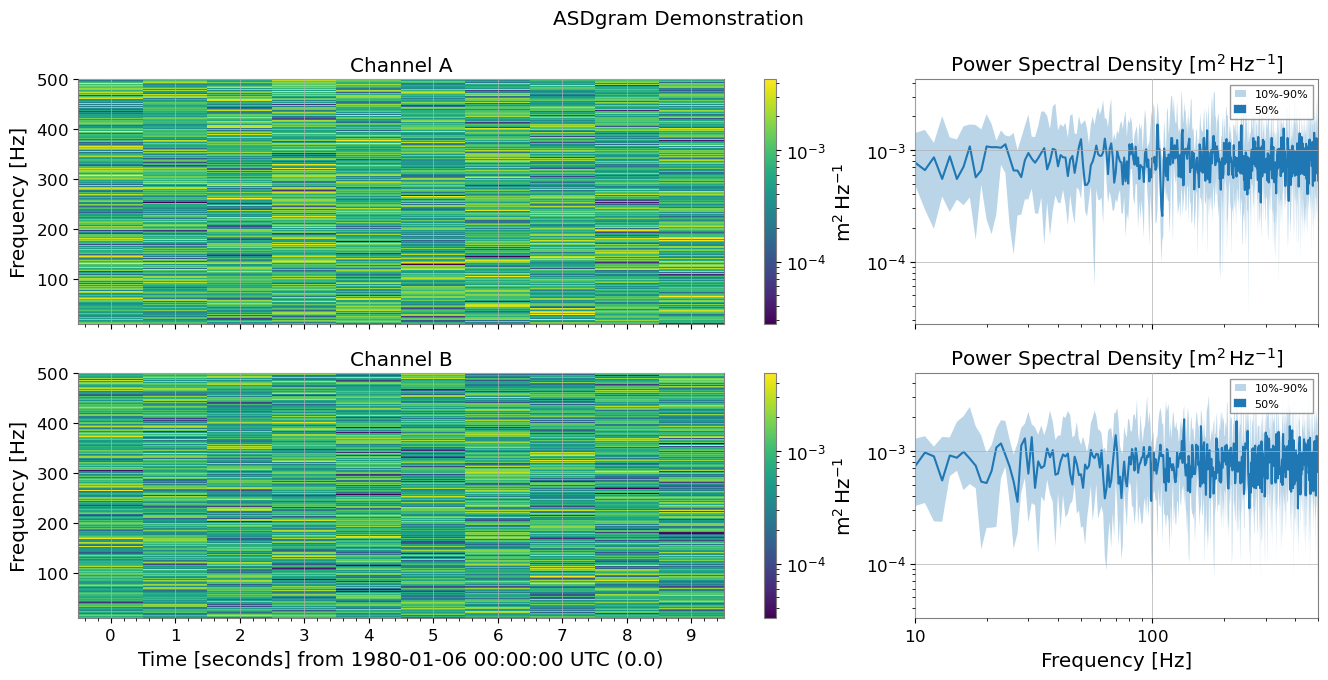

In [9]:
from gwexpy.spectrogram import SpectrogramDict
from gwexpy.timeseries import TimeSeries


# テストデータの生成
def make_sg(name):
    ts = TimeSeries(np.random.randn(2048 * 10), sample_rate=2048, name=name, unit="m")
    return ts.spectrogram(stride=1, fftlength=1, overlap=0.5)


sg_dict = SpectrogramDict({"Channel A": make_sg("A"), "Channel B": make_sg("B")})

# ASDgram プロットの実行
fig, axes = sg_dict.plot_summary(fmin=10, fmax=500, title="ASDgram Demonstration")
plt.show();

## 6. PairPlot Example

以下は `gwexpy.plot.PairPlot` の基本的な使用例です。  
- 2 つの `TimeSeries` を異なるサンプリングレートで作成  
- `PairPlot` が自動で最小サンプルレートにリサンプリングし、共通区間にトリミングします  
- `corner=True`（デフォルト）により左下三角だけが描画されます  

実行すると、対角にヒストグラム、非対角に 2D ヒストグラムが表示されます。

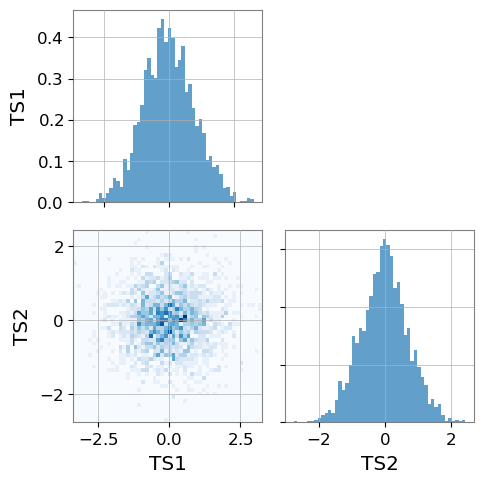

In [10]:
import numpy as np

from gwexpy.plot import PairPlot
from gwexpy.timeseries import TimeSeries

# 2 つの異なるサンプリングレートの TimeSeries を作成
ts1 = TimeSeries(np.random.randn(5000), sample_rate=1024, name="TS1")
ts2 = TimeSeries(np.random.randn(4000), sample_rate=2048, name="TS2")

# PairPlot を作成（corner=True がデフォルト）
pair = PairPlot([ts1, ts2], corner=True)

# 描画
pair.show()